<a href="https://colab.research.google.com/github/DikshantBadawadagi/3D-Chaotic-Maps-with-CBTCC/blob/main/3D-ChaoticMaps-with-CBTCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

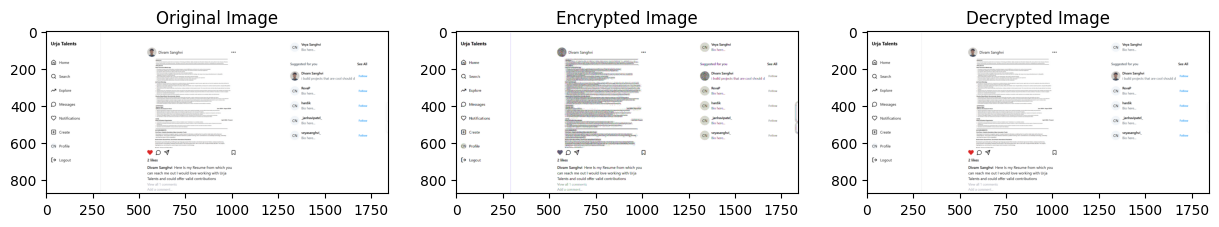

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import base64
import secrets
import struct

class SecureKeyGenerator:
    def __init__(self):
        self.hash_iterations = 10000
        self.salt_length = 32

    def generate_secure_key(self):
        """
        Generate a secure private key with random parameters within valid chaotic ranges
        """
        # Generate random parameters within chaotic ranges
        r_values = np.random.uniform(3.57, 4.0, 4)  # Chaotic range for r
        x_values = np.random.uniform(0.0, 1.0, 4)   # Valid range for x

        # Pack parameters into bytes
        params = struct.pack('dddddddd',
            r_values[0], x_values[0],
            r_values[1], x_values[1],
            r_values[2], x_values[2],
            r_values[3], x_values[3]
        )

        # Generate cryptographic salt
        salt = secrets.token_bytes(self.salt_length)

        # Create key hash using PBKDF2
        key_hash = hashlib.pbkdf2_hmac(
            'sha256',
            params,
            salt,
            self.hash_iterations
        )

        # Combine salt, hash, and encrypted parameters
        # Encrypt parameters using the key_hash as key
        encrypted_params = self._encrypt_params(params, key_hash[:32])
        full_key = salt + key_hash + encrypted_params

        # Encode in base64 for storage/transmission
        return base64.b64encode(full_key).decode('utf-8')

    def _encrypt_params(self, params, key):
        """
        Encrypt parameters using XOR with key
        """
        return bytes(a ^ b for a, b in zip(params, key * (len(params) // len(key) + 1)))

    def _decrypt_params(self, encrypted_params, key):
        """
        Decrypt parameters using XOR with key
        """
        return bytes(a ^ b for a, b in zip(encrypted_params, key * (len(encrypted_params) // len(key) + 1)))

    def retrieve_parameters(self, encoded_key):
        """
        Securely retrieve parameters from the encoded key
        """
        try:
            # Decode the key
            full_key = base64.b64decode(encoded_key)

            # Extract components
            salt = full_key[:self.salt_length]
            key_hash = full_key[self.salt_length:self.salt_length + 32]
            encrypted_params = full_key[self.salt_length + 32:]

            # Decrypt parameters
            decrypted_params = self._decrypt_params(encrypted_params, key_hash[:32])

            # Unpack parameters
            params = struct.unpack('dddddddd', decrypted_params)

            return {
                'r1': params[0], 'x1': params[1],
                'r2': params[2], 'x2': params[3],
                'r3': params[4], 'x3': params[5],
                'r4': params[6], 'x4': params[7]
            }

        except Exception as e:
            raise ValueError(f"Invalid or corrupted private key: {str(e)}")

class ImageCrypto:
    def __init__(self):
        self.key_generator = SecureKeyGenerator()

    def preprocess_image(self, image_path):
        """
        Preprocess the image according to the specified steps
        """
        # Read the image
        img = Image.open(image_path)

        # Convert RGBA to RGB if necessary
        if img.mode == 'RGBA':
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            img = background
        elif img.mode not in ['RGB', 'L']:
            img = img.convert('RGB')

        img_array = np.array(img)

        # Get dimensions
        self.nn1, self.nn2 = img_array.shape[:2]
        self.nn3 = img_array.shape[2] if len(img_array.shape) > 2 else 1

        # Calculate total length
        self.LL1 = self.nn1 * self.nn2 * self.nn3

        # Reshape to one row
        cc2 = img_array.reshape(1, -1)[0]

        # Adjust length to multiple of 8
        self.L1 = (self.LL1 // 8) * 8
        c2 = cc2[:self.L1]

        # Convert to 8-bit binary
        c31 = np.unpackbits(c2.astype(np.uint8))
        c3 = c31.reshape(-1, 64)

        # Store original mode for later
        self.original_mode = img.mode

        # Split into 4 blocks
        return (c3[:, :16], c3[:, 16:32],
                c3[:, 32:48], c3[:, 48:64], c2)

    def generate_chaotic_sequence(self, r, x, sequence_length=16):
        """
        Generate chaotic sequence using logistic map
        """
        sequence = np.zeros(sequence_length)
        for i in range(sequence_length):
            x = r * x * (1 - x)
            sequence[i] = x
        return np.argsort(sequence)

    def process_blocks(self, blocks, params, mode='encrypt'):
        """
        Process blocks using parameters in encrypt or decrypt mode
        """
        processed_blocks = []
        param_pairs = [
            (params['r1'], params['x1']),
            (params['r2'], params['x2']),
            (params['r3'], params['x3']),
            (params['r4'], params['x4'])
        ]

        for block, (r, x) in zip(blocks, param_pairs):
            # Generate index key from chaotic sequence
            index_key = self.generate_chaotic_sequence(r, x)
            processed_block = np.zeros_like(block)

            for i in range(16):
                p = np.where(index_key == i)[0][0]
                if mode == 'encrypt':
                    processed_block[:, i] = block[:, p]
                else:  # decrypt
                    processed_block[:, p] = block[:, i]

            processed_blocks.append(processed_block)

        return processed_blocks

    def blocks_to_image(self, blocks):
        """
        Convert processed blocks back to image
        """
        c3 = np.hstack(blocks)
        cc3 = c3.reshape(-1, 8)
        c5 = np.packbits(cc3)

        img_array = c5.reshape(self.nn1, self.nn2, -1)
        if img_array.shape[-1] == 1:
            img_array = img_array.squeeze()

        return img_array

    def save_image(self, img_array, filename):
        """
        Save image with proper format handling
        """
        img = Image.fromarray(img_array.astype(np.uint8))

        format = filename.split('.')[-1].upper()

        if format == 'PNG':
            img.save(filename, format=format)
        elif format in ['JPEG', 'JPG']:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.save(filename, format='JPEG')
        else:
            img.save(filename)

        return img

    def encrypt_image(self, image_path, private_key=None):
        """
        Encrypt image using provided or new private key
        """
        if private_key is None:
            private_key = self.key_generator.generate_secure_key()

        params = self.key_generator.retrieve_parameters(private_key)
        blocks = self.preprocess_image(image_path)[:4]
        encrypted_blocks = self.process_blocks(blocks, params, 'encrypt')
        encrypted_image = self.blocks_to_image(encrypted_blocks)

        return encrypted_image, private_key

    def decrypt_image(self, encrypted_image_path, private_key):
        """
        Decrypt image using private key
        """
        params = self.key_generator.retrieve_parameters(private_key)
        blocks = self.preprocess_image(encrypted_image_path)[:4]
        decrypted_blocks = self.process_blocks(blocks, params, 'decrypt')
        return self.blocks_to_image(decrypted_blocks)

def demonstrate_usage():
    crypto = ImageCrypto()

    # Example usage
    image_path = "/content/LearnieTask1.png"  # Replace with your image path

    try:
        # Encrypt with provided private key
        private_key = "pENq9g+64ebt1zD2Kw+ThWWt+kWWwlg2of3CtKyKGn4Nxe02NNh2/SeAxFWgjTnigs4jEvWfDzq80aoy137ovCXabs/rLni9JUbHJlMq0t1nY/tllJIAepDgAJLTrw6DqPccfp/Deb0TTXdLxyzb3ZdO3EcvkAB64K1fGEdgNoM="
        encrypted_image, _ = crypto.encrypt_image(image_path, private_key)

        # Save encrypted image (as PNG to preserve all data)
        encrypted_img = crypto.save_image(encrypted_image, "encrypted_image.png")

        # Decrypt using the same private key
        decrypted_image = crypto.decrypt_image("encrypted_image.png", private_key)

        # Save decrypted image
        decrypted_img = crypto.save_image(decrypted_image, "decrypted_image.png")

        # Display results
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(Image.open(image_path))
        plt.title("Original Image")
        plt.subplot(132)
        plt.imshow(encrypted_img)
        plt.title("Encrypted Image")
        plt.subplot(133)
        plt.imshow(decrypted_img)
        plt.title("Decrypted Image")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    demonstrate_usage()

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import base64
import secrets
import struct

class SecureKeyGenerator:
    def __init__(self):
        self.hash_iterations = 10000
        self.salt_length = 32

    def generate_secure_key(self):
        """
        Generate a secure private key with random parameters within valid chaotic ranges for 3D map
        """
        # Generate random parameters within chaotic ranges for 3D logistic map
        # These ranges ensure chaotic behavior
        a_values = np.random.uniform(2.75, 3.99, 3)  # Control parameters
        b_values = np.random.uniform(2.75, 3.99, 3)
        c_values = np.random.uniform(2.75, 3.99, 3)

        # Initial conditions
        x_values = np.random.uniform(0.1, 0.9, 3)
        y_values = np.random.uniform(0.1, 0.9, 3)
        z_values = np.random.uniform(0.1, 0.9, 3)

        # Pack parameters into bytes
        params = struct.pack('27d',
            *a_values, *b_values, *c_values,
            *x_values, *y_values, *z_values
        )

        # Generate cryptographic salt
        salt = secrets.token_bytes(self.salt_length)

        # Create key hash using PBKDF2
        key_hash = hashlib.pbkdf2_hmac(
            'sha512',  # Upgraded to SHA-512
            params,
            salt,
            self.hash_iterations
        )

        # Encrypt parameters using the key_hash
        encrypted_params = self._encrypt_params(params, key_hash[:64])
        full_key = salt + key_hash + encrypted_params

        return base64.b64encode(full_key).decode('utf-8')

    def _encrypt_params(self, params, key):
        return bytes(a ^ b for a, b in zip(params, key * (len(params) // len(key) + 1)))

    def _decrypt_params(self, encrypted_params, key):
        return bytes(a ^ b for a, b in zip(encrypted_params, key * (len(encrypted_params) // len(key) + 1)))

    def retrieve_parameters(self, encoded_key):
        """
        Retrieve 3D map parameters from encoded key
        """
        try:
            full_key = base64.b64decode(encoded_key)

            salt = full_key[:self.salt_length]
            key_hash = full_key[self.salt_length:self.salt_length + 64]
            encrypted_params = full_key[self.salt_length + 64:]

            decrypted_params = self._decrypt_params(encrypted_params, key_hash[:64])
            params = struct.unpack('27d', decrypted_params)

            return {
                'a': params[0:3],
                'b': params[3:6],
                'c': params[6:9],
                'x0': params[9:12],
                'y0': params[12:15],
                'z0': params[15:18]
            }

        except Exception as e:
            raise ValueError(f"Invalid or corrupted private key: {str(e)}")

class ImageCrypto:
    def __init__(self):
        self.key_generator = SecureKeyGenerator()

    def generate_3d_chaos_sequence(self, a, b, c, x0, y0, z0, length):
        """
        Generate chaotic sequence using 3D logistic map
        """
        x, y, z = x0, y0, z0
        sequence = np.zeros(length)

        # Discard initial values to avoid transitional effects
        for _ in range(1000):
            x_new = a * x * (1 - x) + b * y * z
            y_new = b * y * (1 - y) + c * x * z
            z_new = c * z * (1 - z) + a * x * y
            x, y, z = x_new, y_new, z_new

        # Generate sequence
        for i in range(length):
            x_new = a * x * (1 - x) + b * y * z
            y_new = b * y * (1 - y) + c * x * z
            z_new = c * z * (1 - z) + a * x * y
            x, y, z = x_new, y_new, z_new
            sequence[i] = (x + y + z) / 3

        return np.argsort(sequence)

    def preprocess_image(self, image_path):
        """
        Enhanced preprocessing with bit mixing
        """
        img = Image.open(image_path)
        if img.mode == 'RGBA':
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            img = background
        elif img.mode not in ['RGB', 'L']:
            img = img.convert('RGB')

        img_array = np.array(img)
        self.original_shape = img_array.shape

        # Flatten and convert to bits
        flat_array = img_array.flatten()
        bit_array = np.unpackbits(flat_array.astype(np.uint8))

        # Ensure length is multiple of 256 for block processing
        padding_length = (256 - (len(bit_array) % 256)) % 256
        if padding_length:
            bit_array = np.pad(bit_array, (0, padding_length))

        # Reshape into blocks of 256 bits
        blocks = bit_array.reshape(-1, 256)

        return blocks, flat_array

    def process_blocks(self, blocks, params, mode='encrypt'):
        """
        Process blocks using 3D chaotic maps
        """
        processed_blocks = np.zeros_like(blocks)

        for i in range(len(blocks)):
            # Use different parameters for each dimension
            index1 = self.generate_3d_chaos_sequence(
                params['a'][0], params['b'][0], params['c'][0],
                params['x0'][0], params['y0'][0], params['z0'][0],
                256
            )

            # Apply permutation
            if mode == 'encrypt':
                processed_blocks[i] = blocks[i][index1]
            else:
                temp = np.zeros_like(blocks[i])
                temp[index1] = blocks[i]
                processed_blocks[i] = temp

            # Additional diffusion step
            if mode == 'encrypt':
                processed_blocks[i] = np.bitwise_xor(
                    processed_blocks[i],
                    (index1 * 997) % 256  # Prime number for better diffusion
                )
            else:
                processed_blocks[i] = np.bitwise_xor(
                    processed_blocks[i],
                    (index1 * 997) % 256
                )

        return processed_blocks

    def blocks_to_image(self, blocks):
        """
        Convert processed blocks back to image
        """
        # Reshape blocks back to original bit array
        bit_array = blocks.reshape(-1)

        # Trim padding if necessary
        total_bits = np.prod(self.original_shape) * 8
        bit_array = bit_array[:total_bits]

        # Convert bits back to bytes
        byte_array = np.packbits(bit_array)

        # Reshape to original image dimensions
        img_array = byte_array.reshape(self.original_shape)

        return img_array

    def encrypt_image(self, image_path, private_key=None):
        """
        Encrypt image using 3D chaotic system
        """
        if private_key is None:
            private_key = self.key_generator.generate_secure_key()

        params = self.key_generator.retrieve_parameters(private_key)
        blocks, _ = self.preprocess_image(image_path)
        encrypted_blocks = self.process_blocks(blocks, params, 'encrypt')
        encrypted_image = self.blocks_to_image(encrypted_blocks)

        return encrypted_image, private_key

    def decrypt_image(self, encrypted_image_path, private_key):
        """
        Decrypt image using 3D chaotic system
        """
        params = self.key_generator.retrieve_parameters(private_key)
        blocks, _ = self.preprocess_image(encrypted_image_path)
        decrypted_blocks = self.process_blocks(blocks, params, 'decrypt')
        return self.blocks_to_image(decrypted_blocks)

    def save_image(self, img_array, filename):
        """
        Save image with proper format handling
        """
        img = Image.fromarray(img_array.astype(np.uint8))
        format = filename.split('.')[-1].upper()

        if format == 'PNG':
            img.save(filename, format=format)
        elif format in ['JPEG', 'JPG']:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.save(filename, format='JPEG')
        else:
            img.save(filename)

        return img

def demonstrate_usage():
    crypto = ImageCrypto()
    image_path = "/content/DUALITE.png"  # Replace with your image path

    try:
        # Generate new key and encrypt
        encrypted_image, private_key = crypto.encrypt_image(image_path)
        encrypted_img = crypto.save_image(encrypted_image, "encrypted_image.png")

        # Decrypt using the same key
        decrypted_image = crypto.decrypt_image("encrypted_image.png", private_key)
        decrypted_img = crypto.save_image(decrypted_image, "decrypted_image.png")

        # Display results
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(Image.open(image_path))
        plt.title("Original Image")
        plt.subplot(132)
        plt.imshow(encrypted_img)
        plt.title("Encrypted Image")
        plt.subplot(133)
        plt.imshow(decrypted_img)
        plt.title("Decrypted Image")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    demonstrate_usage()

An error occurred: pack expected 27 items for packing (got 18)


error: pack expected 27 items for packing (got 18)

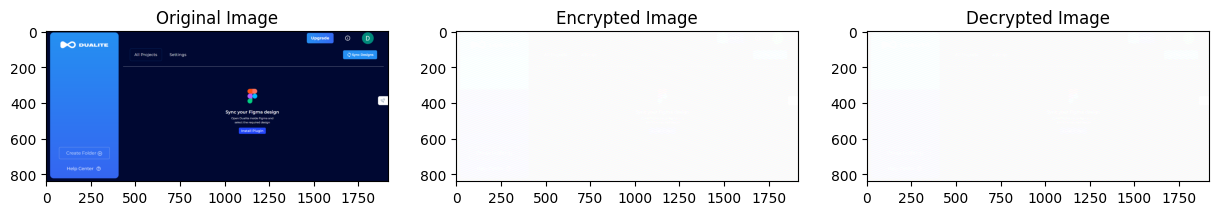

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import base64
import secrets
import struct

class SecureKeyGenerator:
    def __init__(self):
        self.hash_iterations = 10000
        self.salt_length = 32

    def generate_secure_key(self):
        """
        Generate a secure private key with random parameters within valid chaotic ranges for 3D map
        """
        # Generate random parameters within chaotic ranges for 3D logistic map
        # These ranges ensure chaotic behavior
        # Generate 9 control parameters (a, b, c) for the 3D chaotic map
        a_values = np.random.uniform(2.75, 3.99, 3)  # 3 values
        b_values = np.random.uniform(2.75, 3.99, 3)  # 3 values
        c_values = np.random.uniform(2.75, 3.99, 3)  # 3 values

        # Generate 9 initial conditions (x0, y0, z0)
        x_values = np.random.uniform(0.1, 0.9, 3)  # 3 values
        y_values = np.random.uniform(0.1, 0.9, 3)  # 3 values
        z_values = np.random.uniform(0.1, 0.9, 3)  # 3 values

        # Add 9 additional parameters (e.g., diffusion or scaling factors)
        extra_params = np.random.uniform(0.1, 0.9, 9)  # 9 values

        # Pack all 27 parameters
        params = struct.pack('27d',
           *a_values, *b_values, *c_values,
           *x_values, *y_values, *z_values,
          *extra_params
        )


        # Generate cryptographic salt
        salt = secrets.token_bytes(self.salt_length)

        # Create key hash using PBKDF2
        key_hash = hashlib.pbkdf2_hmac(
            'sha512',  # Upgraded to SHA-512
            params,
            salt,
            self.hash_iterations
        )

        # Encrypt parameters using the key_hash
        encrypted_params = self._encrypt_params(params, key_hash[:64])
        full_key = salt + key_hash + encrypted_params

        return base64.b64encode(full_key).decode('utf-8')

    def _encrypt_params(self, params, key):
        return bytes(a ^ b for a, b in zip(params, key * (len(params) // len(key) + 1)))

    def _decrypt_params(self, encrypted_params, key):
        return bytes(a ^ b for a, b in zip(encrypted_params, key * (len(encrypted_params) // len(key) + 1)))

    def retrieve_parameters(self, encoded_key):
        """
        Retrieve 3D map parameters from encoded key
        """
        try:
            full_key = base64.b64decode(encoded_key)

            salt = full_key[:self.salt_length]
            key_hash = full_key[self.salt_length:self.salt_length + 64]
            encrypted_params = full_key[self.salt_length + 64:]

            decrypted_params = self._decrypt_params(encrypted_params, key_hash[:64])
            params = struct.unpack('27d', decrypted_params)

            return {
                'a': params[0:3],
                'b': params[3:6],
                'c': params[6:9],
                'x0': params[9:12],
                'y0': params[12:15],
                'z0': params[15:18]
            }

        except Exception as e:
            raise ValueError(f"Invalid or corrupted private key: {str(e)}")

class ImageCrypto:
    def __init__(self):
        self.key_generator = SecureKeyGenerator()

    def generate_3d_chaos_sequence(self, a, b, c, x0, y0, z0, length):
        """
        Generate chaotic sequence using 3D logistic map
        """
        x, y, z = x0, y0, z0
        sequence = np.zeros(length)

        # Discard initial values to avoid transitional effects
        for _ in range(1000):
            x_new = a * x * (1 - x) + b * y * z
            y_new = b * y * (1 - y) + c * x * z
            z_new = c * z * (1 - z) + a * x * y
            x, y, z = x_new, y_new, z_new

        # Generate sequence
        for i in range(length):
            x_new = a * x * (1 - x) + b * y * z
            y_new = b * y * (1 - y) + c * x * z
            z_new = c * z * (1 - z) + a * x * y
            x, y, z = x_new, y_new, z_new
            sequence[i] = (x + y + z) / 3

        return np.argsort(sequence)

    def preprocess_image(self, image_path):
        """
        Enhanced preprocessing with bit mixing
        """
        img = Image.open(image_path)
        if img.mode == 'RGBA':
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            img = background
        elif img.mode not in ['RGB', 'L']:
            img = img.convert('RGB')

        img_array = np.array(img)
        self.original_shape = img_array.shape

        # Flatten and convert to bits
        flat_array = img_array.flatten()
        bit_array = np.unpackbits(flat_array.astype(np.uint8))

        # Ensure length is multiple of 256 for block processing
        padding_length = (256 - (len(bit_array) % 256)) % 256
        if padding_length:
            bit_array = np.pad(bit_array, (0, padding_length))

        # Reshape into blocks of 256 bits
        blocks = bit_array.reshape(-1, 256)

        return blocks, flat_array

    def process_blocks(self, blocks, params, mode='encrypt'):
        """
        Process blocks using 3D chaotic maps
        """
        processed_blocks = np.zeros_like(blocks)

        for i in range(len(blocks)):
            # Use different parameters for each dimension
            index1 = self.generate_3d_chaos_sequence(
                params['a'][0], params['b'][0], params['c'][0],
                params['x0'][0], params['y0'][0], params['z0'][0],
                256
            )

            # Apply permutation
            if mode == 'encrypt':
                processed_blocks[i] = blocks[i][index1]
            else:
                temp = np.zeros_like(blocks[i])
                temp[index1] = blocks[i]
                processed_blocks[i] = temp

            # Additional diffusion step
            if mode == 'encrypt':
                processed_blocks[i] = np.bitwise_xor(
                    processed_blocks[i],
                    (index1 * 997) % 256  # Prime number for better diffusion
                )
            else:
                processed_blocks[i] = np.bitwise_xor(
                    processed_blocks[i],
                    (index1 * 997) % 256
                )

        return processed_blocks

    def blocks_to_image(self, blocks):
        """
        Convert processed blocks back to image
        """
        # Reshape blocks back to original bit array
        bit_array = blocks.reshape(-1)

        # Trim padding if necessary
        total_bits = np.prod(self.original_shape) * 8
        bit_array = bit_array[:total_bits]

        # Convert bits back to bytes
        byte_array = np.packbits(bit_array)

        # Reshape to original image dimensions
        img_array = byte_array.reshape(self.original_shape)

        return img_array

    def encrypt_image(self, image_path, private_key=None):
        """
        Encrypt image using 3D chaotic system
        """
        if private_key is None:
            private_key = self.key_generator.generate_secure_key()

        params = self.key_generator.retrieve_parameters(private_key)
        blocks, _ = self.preprocess_image(image_path)
        encrypted_blocks = self.process_blocks(blocks, params, 'encrypt')
        encrypted_image = self.blocks_to_image(encrypted_blocks)

        return encrypted_image, private_key

    def decrypt_image(self, encrypted_image_path, private_key):
        """
        Decrypt image using 3D chaotic system
        """
        params = self.key_generator.retrieve_parameters(private_key)
        blocks, _ = self.preprocess_image(encrypted_image_path)
        decrypted_blocks = self.process_blocks(blocks, params, 'decrypt')
        return self.blocks_to_image(decrypted_blocks)

    def save_image(self, img_array, filename):
        """
        Save image with proper format handling
        """
        img = Image.fromarray(img_array.astype(np.uint8))
        format = filename.split('.')[-1].upper()

        if format == 'PNG':
            img.save(filename, format=format)
        elif format in ['JPEG', 'JPG']:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.save(filename, format='JPEG')
        else:
            img.save(filename)

        return img

def demonstrate_usage():
    crypto = ImageCrypto()
    image_path = "/content/DUALITE.png"  # Replace with your image path

    try:
        # Generate new key and encrypt
        encrypted_image, private_key = crypto.encrypt_image(image_path)
        encrypted_img = crypto.save_image(encrypted_image, "encrypted_image.png")

        # Decrypt using the same key
        decrypted_image = crypto.decrypt_image("encrypted_image.png", private_key)
        decrypted_img = crypto.save_image(decrypted_image, "decrypted_image.png")

        # Display results
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(Image.open(image_path))
        plt.title("Original Image")
        plt.subplot(132)
        plt.imshow(encrypted_img)
        plt.title("Encrypted Image")
        plt.subplot(133)
        plt.imshow(decrypted_img)
        plt.title("Decrypted Image")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    demonstrate_usage()



1D Chaotic maps with CBTCC

In [ ]:
import numpy as np
from PIL import Image

class EnhancedImageCrypto:
    def __init__(self):
        pass

    def generate_chaotic_sequence(self, r, x, length):
        sequence = np.zeros(length)
        for i in range(length):
            x = r * x * (1 - x)
            sequence[i] = x
        return sequence

    def generate_tk_and_iv(self, params):
        tks = []
        for i in range(4):
            r = params[f'r{i+1}']
            x = params[f'x{i+1}']
            sequence = self.generate_chaotic_sequence(r, x, 16)
            tk = (sequence > 0.5).astype(np.uint8)
            tks.append(tk)
        r_mean = np.mean([params[f'r{i+1}'] for i in range(4)])
        x_mean = np.mean([params[f'x{i+1}'] for i in range(4)])
        iv_sequence = self.generate_chaotic_sequence(r_mean, x_mean, 16)
        iv = (iv_sequence > 0.5).astype(np.uint8)
        return tks, iv

    def generate_ikeys(self, params):
        ikeys = []
        for i in range(4):
            r = params[f'r{i+1}']
            x = params[f'x{i+1}']
            sequence = self.generate_chaotic_sequence(r, x, 16)
            ikey = np.argsort(sequence)
            ikeys.append(ikey)
        return ikeys

    def apply_transformation(self, row, tk):
        transformed = np.zeros(16, dtype=np.uint8)
        for j in range(16):
            val = row[j] ^ tk[j]
            if j % 2 == 1:
                val ^= tk[j-1]
            else:
                val ^= tk[(j+1) % 16]
            transformed[j] = val
        return transformed

    def apply_inverse_transformation(self, row, tk):
        original = np.zeros(16, dtype=np.uint8)
        for j in range(15, -1, -1):
            val = row[j]
            if j % 2 == 1:
                val ^= tk[j-1]
            else:
                val ^= tk[(j+1) % 16]
            original[j] = val ^ tk[j]
        return original

    def preprocess_image(self, image_path):
        img = Image.open(image_path).convert('L')
        self.original_shape = img.size
        img_array = np.array(img, dtype=np.uint8)
        flat = img_array.flatten()
        binary = np.unpackbits(flat)
        pad_length = (64 - (len(binary) % 64)) % 64
        padded = np.pad(binary, (0, pad_length), mode='constant')
        rows = padded.size // 64
        reshaped = padded.reshape(rows, 64)
        blocks = [reshaped[:, i*16:(i+1)*16] for i in range(4)]
        return blocks

    def process_blocks(self, blocks, tks, iv, mode='encrypt'):
        num_rows = blocks[0].shape[0]
        processed = [np.zeros_like(b) for b in blocks]
        for j in range(num_rows):
            prev = iv.copy()
            for i in range(4):
                if mode == 'encrypt':
                    P = blocks[i][j, :]
                    transformed = self.apply_transformation(P, tks[i])
                    C = transformed ^ prev
                    processed[i][j, :] = C
                    prev = C.copy()
                else:
                    C = blocks[i][j, :]
                    transformed = C ^ prev
                    P = self.apply_inverse_transformation(transformed, tks[i])
                    processed[i][j, :] = P
                    prev = C.copy()
        return processed

    def shuffle_columns(self, block, ikey):
        return block[:, ikey]

    def unshuffle_columns(self, block, ikey):
        reverse_ikey = np.zeros_like(ikey)
        reverse_ikey[ikey] = np.arange(16)
        return block[:, reverse_ikey]

    def blocks_to_image(self, blocks):
        binary = np.hstack(blocks)
        flat = np.packbits(binary.flatten())
        total_pixels = self.original_shape[0] * self.original_shape[1]
        flat = flat[:total_pixels]
        return Image.fromarray(flat.reshape(self.original_shape[1], self.original_shape[0]).astype(np.uint8))

    def encrypt(self, image_path, params):
        blocks = self.preprocess_image(image_path)
        tks, iv = self.generate_tk_and_iv(params)
        ikeys = self.generate_ikeys(params)
        encrypted_blocks = self.process_blocks(blocks, tks, iv, 'encrypt')
        shuffled_blocks = [self.shuffle_columns(b, ikey) for b, ikey in zip(encrypted_blocks, ikeys)]
        return self.blocks_to_image(shuffled_blocks)

    def decrypt(self, encrypted_image_path, params):
        blocks = self.preprocess_image(encrypted_image_path)
        tks, iv = self.generate_tk_and_iv(params)
        ikeys = self.generate_ikeys(params)
        unshuffled_blocks = [self.unshuffle_columns(b, ikey) for b, ikey in zip(blocks, ikeys)]
        decrypted_blocks = self.process_blocks(unshuffled_blocks, tks, iv, 'decrypt')
        return self.blocks_to_image(decrypted_blocks)

params = {'r1': 3.67, 'x1': 0.31, 'r2': 3.75, 'x2': 0.22,
          'r3': 3.95, 'x3': 0.16, 'r4': 3.61, 'x4': 0.29}
crypto = EnhancedImageCrypto()
encrypted_img = crypto.encrypt('/content/download.jpg', params)
encrypted_img.save('encrypted1.png')
decrypted_img = crypto.decrypt('encrypted1.png', params)
decrypted_img.save('decrypted1.png')

3D chaotic maps with CBTCC

In [ ]:
import numpy as np
from PIL import Image

class EnhancedImageCrypto:
    def __init__(self):
        self.original_shape = None

    def generate_3d_chaotic_sequence(self, r1, r2, r3, x0, y0, z0, length, gamma=0.1):
        """Generate a stable sequence using a 3D logistic chaotic map."""
        x, y, z = x0, y0, z0
        sequence = np.zeros(length)
        for i in range(length):
            x_new = r1 * x * (1 - x) + gamma * y**2 + gamma * z
            x_new = x_new % 1
            y_new = r2 * y * (1 - y) + gamma * x_new**2 + gamma * z
            y_new = y_new % 1
            z_new = r3 * z * (1 - z) + gamma * x_new + gamma * y_new
            z_new = z_new % 1
            x, y, z = x_new, y_new, z_new
            sequence[i] = x
        return sequence

    def generate_tk_and_iv(self, params):
        """Generate 16 TKs and an IV using 3D chaotic maps."""
        tks = []
        for i in range(16):
            r1 = params[f'r{i*3+1}']
            r2 = params[f'r{i*3+2}']
            r3 = params[f'r{i*3+3}']
            x0 = params[f'x{i+1}']
            y0 = params[f'y{i+1}']
            z0 = params[f'z{i+1}']
            sequence = self.generate_3d_chaotic_sequence(r1, r2, r3, x0, y0, z0, 16)
            tk = (sequence > 0.5).astype(np.uint8)
            tks.append(tk)
        r_mean = np.mean([params[f'r{i+1}'] for i in range(48)])
        x_mean = np.mean([params[f'x{i+1}'] for i in range(16)])
        y_mean = np.mean([params[f'y{i+1}'] for i in range(16)])
        z_mean = np.mean([params[f'z{i+1}'] for i in range(16)])
        iv_sequence = self.generate_3d_chaotic_sequence(r_mean, r_mean, r_mean, x_mean, y_mean, z_mean, 16)
        iv = (iv_sequence > 0.5).astype(np.uint8)
        return tks, iv

    def generate_ikeys(self, params):
        """Generate 16 IKEYs for shuffling using 3D chaotic maps."""
        ikeys = []
        for i in range(16):
            r1 = params[f'r{i*3+1}']
            r2 = params[f'r{i*3+2}']
            r3 = params[f'r{i*3+3}']
            x0 = params[f'x{i+1}']
            y0 = params[f'y{i+1}']
            z0 = params[f'z{i+1}']
            sequence = self.generate_3d_chaotic_sequence(r1, r2, r3, x0, y0, z0, 16)
            ikey = np.argsort(sequence)
            ikeys.append(ikey)
        return ikeys

    def apply_transformation(self, row, tk):
        """Apply CBTCC transformation to a 16-bit row."""
        transformed = np.zeros(16, dtype=np.uint8)
        for j in range(16):
            val = row[j] ^ tk[j]
            if j % 2 == 1:
                val ^= tk[j-1]
            else:
                val ^= tk[(j+1) % 16]
            transformed[j] = val
        return transformed

    def apply_inverse_transformation(self, row, tk):
        """Apply inverse CBTCC transformation."""
        original = np.zeros(16, dtype=np.uint8)
        for j in range(15, -1, -1):
            val = row[j]
            if j % 2 == 1:
                val ^= tk[j-1]
            else:
                val ^= tk[(j+1) % 16]
            original[j] = val ^ tk[j]
        return original

    def preprocess_image(self, image_path):
        """Convert image to binary matrix with 256 columns (16 blocks x 16 cols)."""
        img = Image.open(image_path).convert('L')
        self.original_shape = img.size
        img_array = np.array(img, dtype=np.uint8)
        flat = img_array.flatten()
        binary = np.unpackbits(flat)
        pad_length = (256 - (len(binary) % 256)) % 256
        padded = np.pad(binary, (0, pad_length), mode='constant')
        rows = padded.size // 256
        reshaped = padded.reshape(rows, 256)
        blocks = [reshaped[:, i*16:(i+1)*16] for i in range(16)]
        return blocks

    def process_blocks(self, blocks, tks, iv, mode='encrypt'):
        """Apply CBTCC to all 16 blocks."""
        num_rows = blocks[0].shape[0]
        processed = [np.zeros_like(b) for b in blocks]
        for j in range(num_rows):
            prev = iv.copy()
            for i in range(16):
                if mode == 'encrypt':
                    P = blocks[i][j, :]
                    transformed = self.apply_transformation(P, tks[i])
                    C = transformed ^ prev
                    processed[i][j, :] = C
                    prev = C.copy()
                else:
                    C = blocks[i][j, :]
                    transformed = C ^ prev
                    P = self.apply_inverse_transformation(transformed, tks[i])
                    processed[i][j, :] = P
                    prev = C.copy()
        return processed

    def shuffle_columns(self, block, ikey):
        """Shuffle columns within a block."""
        return block[:, ikey]

    def unshuffle_columns(self, block, ikey):
        """Unshuffle columns within a block."""
        reverse_ikey = np.zeros_like(ikey)
        reverse_ikey[ikey] = np.arange(16)
        return block[:, reverse_ikey]

    def blocks_to_image(self, blocks):
        """Convert blocks back to image."""
        binary = np.hstack(blocks)
        flat = np.packbits(binary.flatten())
        total_pixels = self.original_shape[0] * self.original_shape[1]
        flat = flat[:total_pixels]
        return Image.fromarray(flat.reshape(self.original_shape[1], self.original_shape[0]).astype(np.uint8))

    def encrypt(self, image_path, params):
        """Encrypt image with CBTCC and shuffling."""
        blocks = self.preprocess_image(image_path)
        tks, iv = self.generate_tk_and_iv(params)
        ikeys = self.generate_ikeys(params)
        encrypted_blocks = self.process_blocks(blocks, tks, iv, 'encrypt')
        shuffled_blocks = [self.shuffle_columns(b, ikey) for b, ikey in zip(encrypted_blocks, ikeys)]
        return self.blocks_to_image(shuffled_blocks)

    def decrypt(self, encrypted_image_path, params):
        """Decrypt image by unshuffling and inverse CBTCC."""
        blocks = self.preprocess_image(encrypted_image_path)
        tks, iv = self.generate_tk_and_iv(params)
        ikeys = self.generate_ikeys(params)
        unshuffled_blocks = [self.unshuffle_columns(b, ikey) for b, ikey in zip(blocks, ikeys)]
        decrypted_blocks = self.process_blocks(unshuffled_blocks, tks, iv, 'decrypt')
        return self.blocks_to_image(decrypted_blocks)


params = {
    'r1': 3.8, 'r2': 3.7, 'r3': 3.6, 'x1': 0.1, 'y1': 0.2, 'z1': 0.3,
    'r4': 3.65, 'r5': 3.75, 'r6': 3.85, 'x2': 0.15, 'y2': 0.25, 'z2': 0.35,
    'r7': 3.9, 'r8': 3.67, 'r9': 3.77, 'x3': 0.2, 'y3': 0.3, 'z3': 0.4,
    'r10': 3.82, 'r11': 3.72, 'r12': 3.62, 'x4': 0.25, 'y4': 0.35, 'z4': 0.45,
    'r13': 3.68, 'r14': 3.78, 'r15': 3.88, 'x5': 0.3, 'y5': 0.4, 'z5': 0.5,
    'r16': 3.83, 'r17': 3.73, 'r18': 3.63, 'x6': 0.35, 'y6': 0.45, 'z6': 0.55,
    'r19': 3.69, 'r20': 3.79, 'r21': 3.89, 'x7': 0.4, 'y7': 0.5, 'z7': 0.6,
    'r22': 3.84, 'r23': 3.74, 'r24': 3.64, 'x8': 0.45, 'y8': 0.55, 'z8': 0.65,
    'r25': 3.81, 'r26': 3.71, 'r27': 3.61, 'x9': 0.5, 'y9': 0.6, 'z9': 0.7,
    'r28': 3.86, 'r29': 3.76, 'r30': 3.66, 'x10': 0.55, 'y10': 0.65, 'z10': 0.75,
    'r31': 3.87, 'r32': 3.77, 'r33': 3.67, 'x11': 0.6, 'y11': 0.7, 'z11': 0.8,
    'r34': 3.82, 'r35': 3.72, 'r36': 3.62, 'x12': 0.65, 'y12': 0.75, 'z12': 0.85,
    'r37': 3.88, 'r38': 3.78, 'r39': 3.68, 'x13': 0.7, 'y13': 0.8, 'z13': 0.9,
    'r40': 3.83, 'r41': 3.73, 'r42': 3.63, 'x14': 0.75, 'y14': 0.85, 'z14': 0.95,
    'r43': 3.89, 'r44': 3.79, 'r45': 3.69, 'x15': 0.8, 'y15': 0.9, 'z15': 0.1,
    'r46': 3.84, 'r47': 3.74, 'r48': 3.64, 'x16': 0.85, 'y16': 0.95, 'z16': 0.15
}

crypto = EnhancedImageCrypto()
encrypted_img = crypto.encrypt('/content/download.jpg', params)
encrypted_img.save('encrypted_16blocks.png')
decrypted_img = crypto.decrypt('encrypted_16blocks.png', params)
decrypted_img.save('decrypted_16blocks.png')